In [27]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns  # >= 0.9
sns.set(context='talk', style='whitegrid', color_codes=True)

In [2]:
mpl.rcParams['figure.figsize'] = (10,6)

# Preamble



Type Ia supernovae (SNe Ia) are generally thought to be the thermonuclear disruption of a carbon-oxygen white-dwarf star (WD) in a binary system (see, e.g., Hillebrandt & Niemeyer 2000 for a review), but their formation scenarios and exact progenitor systems are still ambiguous. The photospheric velocity of SNe Ia measured from the strong Si II λ6355 absorption line in their spectrum (e.g., Silverman et al. 2012) at the time of peak brightness is an important parameter for studying the various properties of SNe Ia. The ejecta velocity distribution is also a possible clue for revealing asymmetries in SN Ia explosions. Recent studies reveal that the distribution of SN Ia velocity does not originate from a uniform class. [Wang, X. et al. (2013)](https://arxiv.org/abs/1303.2601) and [Zheng et al. (2018)](https://arxiv.org/abs/1712.01495) show that there exists a subclass of SNe Ia with high velocities (Figures 1 and 2), indicating a different origin for some SNe Ia.

Asymmetric SN Ia explosions could cause different measured ejecta velocities observed from different lines of sight. We intend to model the ejecta velocity of SNe Ia seen from different lines of sight through numerical simulations to test if the simulated velocity distribution could match the observed velocity distribution. We expect the model to demonstrate properties of velocity, ejecta size, and rarity of the high-velocity ejecta compared to the low-velocity. The results of the simulations will be a random sample of the velocity distribution to be compared with the real data.

Due to the limited time alloted for this project, a few descoping option was used. The original method of parameter estimation was MCMC which the posterior of the parameters were difficult to interpret. Further convergence test was needed therefore I decided MCMC was too time consuming. Parameter estimation was descoped form MCMC to grid search which provides a single set of best estimated parameters instead of a posterior. A quality slice in Si II velocity was also made to descope so that the methods matches those in Wang, X. et al. (2013) easily. Finally, the last descope made as assuming that all SNe Ia have high-velocity ejecta instead of using a prior.


# The Data

The data came from [Wang, X. et al (2013) supplementary materials](https://science.sciencemag.org/content/340/6129/170/tab-figures-data). A quality cut in Si II velocity was made to only include velocities between $0.7$ to $1.8$ ($10^4$ $\text{km/s}$). There exist an error column for Si II velocity however was ignored as the errors were suspiciously all integers. Further inquiry from the original author or the original observers (Lick Observatory Supernovae Search) is required to interpret the errors.

In [3]:
def import_sn_data(fpath='sn_data.txt'):
    df = pd.read_csv(fpath, sep='\s+', index_col=0, na_values=['...', 'NaN'])
    df = clean_sn_data(df)
    return df
    
    
def clean_sn_data(df):
    df = (df
          .iloc[:,[0,9]]
          .loc[~df['v_siII'].isnull(), :]
          .loc[(df['v_siII'] > 0.7) & (df['v_siII'] < 1.8)]
         )
    return df

sn_data = import_sn_data()
display(sn_data.head())
display(sn_data.info(verbose=True))
display(sn_data.describe())

,SN_Host,v_siII
SN,,
1998de,NGC252,1.13
1998dk,UGC139,1.27
1998ef,UGC646,1.33
1998es,NGC632,1.18
1999aa,NGC2595,1.04


<class 'pandas.core.frame.DataFrame'>
Index: 153 entries, 1998de to 2008hv
Data columns (total 2 columns):
SN_Host    153 non-null object
v_siII     153 non-null float64
dtypes: float64(1), object(1)
memory usage: 3.6+ KB


None

,v_siII
count,153.000000
mean,1.141438
std,0.150028
min,0.810000
25%,1.040000
50%,1.100000
75%,1.210000
max,1.600000


Here, the right histogram plotted in Figure 1 from Wang, X. et al. (2013), is replotted below

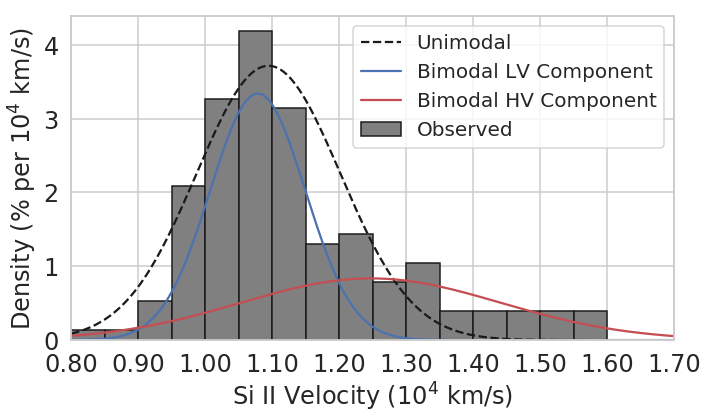

In [144]:
from scipy.optimize import curve_fit
from mcmc import gaussian, bimodal_gaussian

x = sn_data['v_siII']
bins = np.arange(0.8, 1.75, 0.05)
plt.hist(x, density=True, bins=bins, color='gray', fill=True, edgecolor='k', joinstyle='miter', label='Observed')

# Unimodal Gaussian
xrange = np.linspace(bins.min(), bins.max(), 200)
ydata, xdata = np.histogram(x, bins=np.arange(0.8, 1.75, 0.1), density=True)
xdata = (xdata[:-1] + xdata[1:]) / 2
opt, cov = curve_fit(gaussian, xdata, ydata, p0=[np.mean(x), np.std(x)])
plt.plot(xrange, gaussian(xrange, *opt), '--', color='k', label='Unimodal')

# Bimodal Gaussian
opt, cov = curve_fit(bimodal_gaussian, xdata, ydata, p0=[1.1, 1, 1.5, 1, 0.5])
# plt.plot(xrange, bimodal_gaussian(xrange, *opt), color='gray', label='Bimodal')
plt.plot(xrange, opt[4]*gaussian(xrange, *opt[0:2]), 'b', label='Bimodal LV Component')
plt.plot(xrange, (1-opt[4])*gaussian(xrange, *opt[2:4]), 'r', label='Bimodal HV Component')

# Plot config
plt.xticks(bins[::2], [f'{tick:.2f}' for tick in bins[::2]])
plt.xlim(bins.min(), bins.max())
plt.legend(fontsize=20)
plt.xlabel('Si II Velocity ($10^4$ km/s)')
plt.ylabel('Density (% per $10^4$ km/s)')

# Save results
plt.tight_layout()
plt.savefig('velocity_dist.png', orientation='landscape', format='png', dpi=600)
np.savetxt('bimodal_params.txt', opt)

# Method

Typical velocity and size of the high and low velocity ejecta can be estimated with the a two-dimensional toy model where the ejecta is only asymmetric angularly. The toy model assumes that every SNe Ia has a high-velocity ejecta (HV) and low-velocity ejecta (LV) sampled from two indepenent normal distribution $\mathcal N(\mu_\text{LV}, \sigma_\text{LV})$ and $\mathcal N(\mu_\text{HV}, \sigma_\text{HV})$. The size of the high-ejecta is the angular spread $\theta$. The high-velocity ejecta can only be observed if the line of sight (LOS) is within its spread. Thus, the simulation follow as so:

Given the parameters $\theta$, $\mu_\text{LV}$, $\sigma_\text{LV}$, $\mu_\text{HV}$, and $\sigma_\text{HV}$:
1. Sample the LOS from a uniform distribution:

$$
\text{LOS} \sim \text{Uniform}(0, 180)
$$

2. Sample the velocity distribution depend on if HV or LV can be observed:

$$
v \sim
\begin{cases}
\mathcal N(\mu_\text{HV}, \sigma_\text{HV}) & -\frac{\theta}{2} < \text{LOS} < \frac{\theta}{2}\\
\mathcal N(\mu_\text{LV}, \sigma_\text{LV} & \text{otherwise.}
\end{cases}
$$

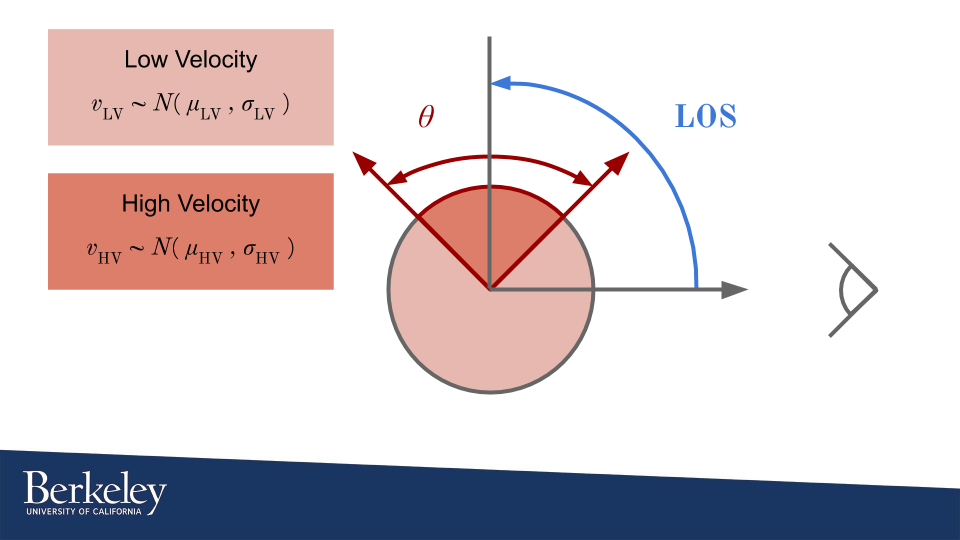

## Parameter Estimation - Grid Search

Using the simulation above, the best estimated parameters is determined by a grid search amongst all five parameters. The range of the grid is given below. The interval syntax is range(low, high, step):

$$
\begin{align}
\theta &\in \text{range}(0, 180, 180) \quad [\text{degrees}]\\
\mu_\text{HV} &\in \text{range}(1.3, 5, 10) \quad [10^4\text{km/s}]\\
\sigma_\text{HV} &\in \text{range}(0.1, 0.3, 5) \quad [10^4\text{km/s}]\\
\mu_\text{LV} &\in \text{range}(1., 1.3, 10) \quad [10^4\text{km/s}]\\
\sigma_\text{LV} &\in \text{range}(0.1, 0.5, 5) \quad [10^4\text{km/s}]
\end{align}
$$

In total, 45000 sets of parameters were simulated. Each simulation was scored by the Kolmogorov-Smirov (KS) test. Then, the top 100 KS scoring parameters is stored. The code for the grid-search and simulation is provided in the [Appendix](#Appendix) under the section [Grid Search](#Grid-Search).

# Results

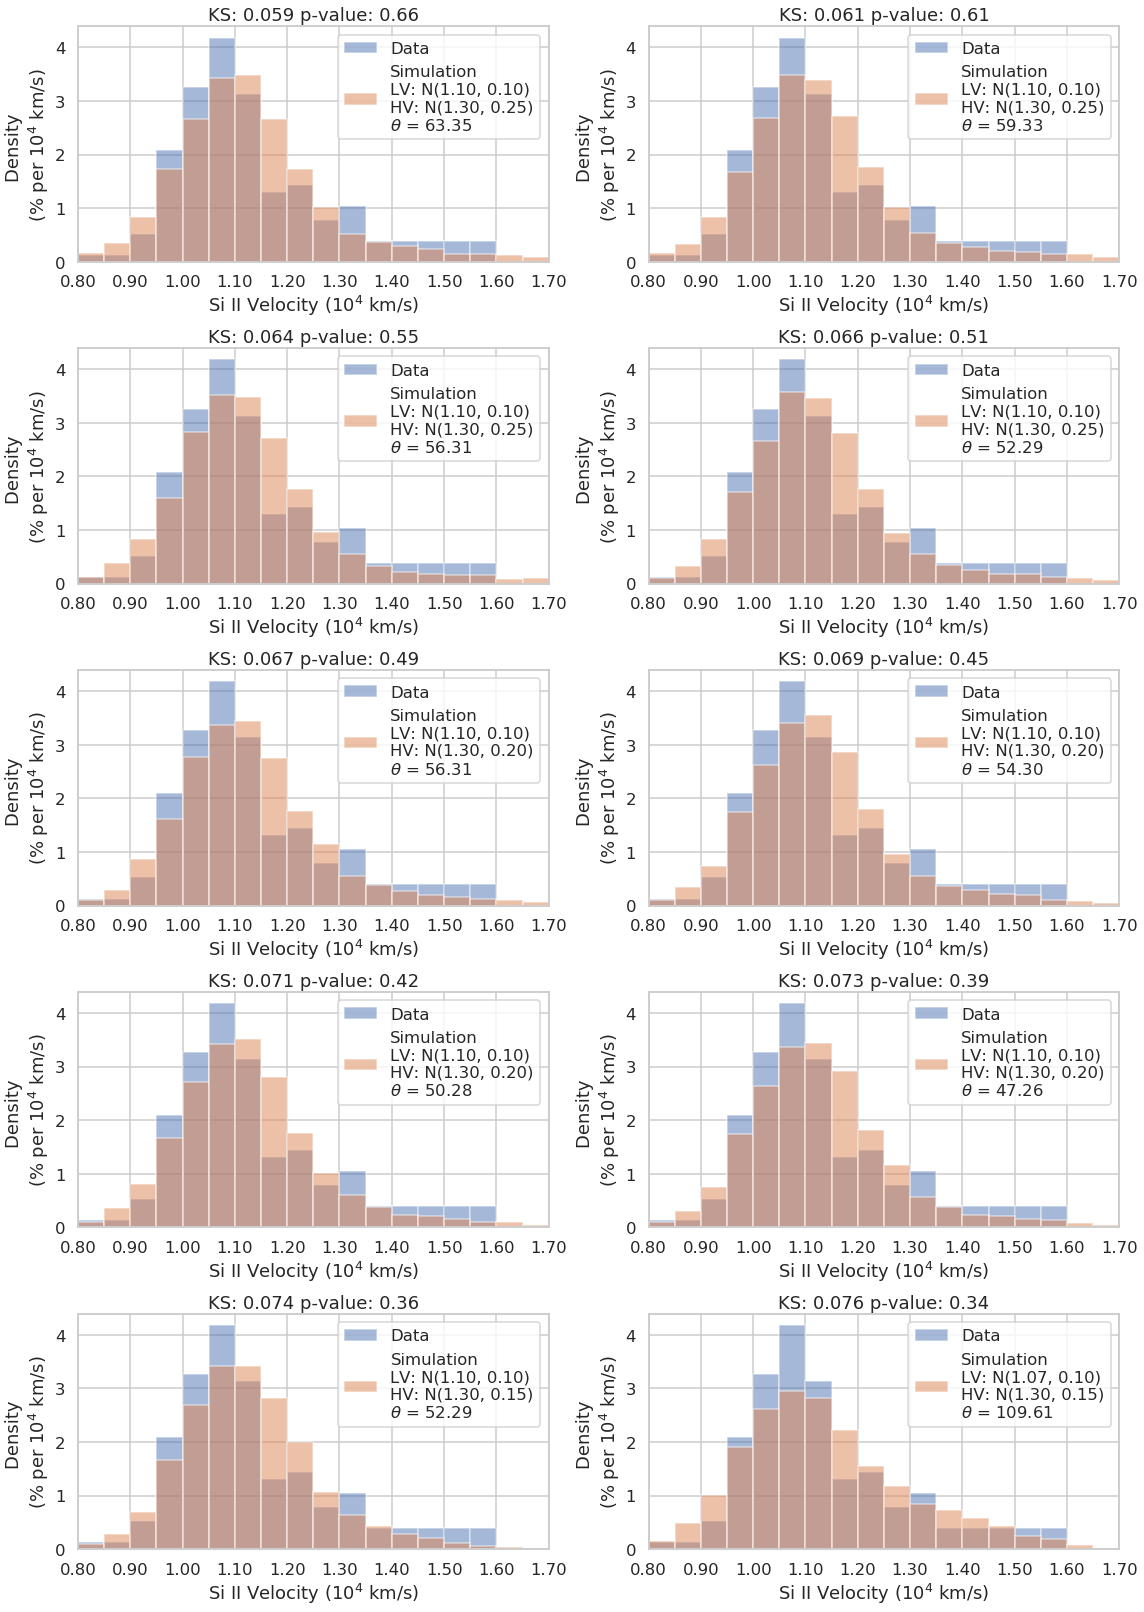

In [25]:
import pickle as pkl

with open('scores.pkl.bak', 'rb') as f:
    scores = pkl.load(f)

sort_idx = np.argsort(scores['ks'])
ks = scores['ks'][sort_idx]
pvalue = scores['pvalue'][sort_idx]
vs = scores['vs'][sort_idx]
params = scores['params'][sort_idx]

nrows, ncols = 5, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(16, 4.5*nrows))

for i in range(nrows*ncols):
    best_vs = vs[i]
    best_ks = ks[i]
    best_pvalue = pvalue[i]
    best_params = params[i]
    mu_LV, sigma_LV = best_params['mu_LV'], best_params['sigma_LV']
    mu_HV, sigma_HV = best_params['mu_HV'], best_params['sigma_HV']
    theta = best_params['theta']
    
    ax = axs[i//ncols, i%ncols]
    bins = np.arange(0.8, 1.75, 0.05)
    ax.hist(sn_data['v_siII'], bins, density=True, alpha=0.5, label='Data')
    ax.hist(best_vs, bins, density=True, alpha=0.5, 
            label=(
                f'Simulation\n' + 
                f'LV: N({mu_LV:.2f}, {sigma_LV:.2f})\n' + 
                f'HV: N({mu_HV:.2f}, {sigma_HV:.2f})\n' + 
                fr'$\theta$ = {theta:.2f}'
            )
           )
    ax.set_xlabel('Si II Velocity ($10^4$ km/s)')
    ax.set_ylabel('Density \n(% per $10^4$ km/s)')
    ax.set_title(f"KS: {best_ks:.3f} p-value: {best_pvalue:.2f}")
    ax.set_xticks(bins[::2])
    ax.set_xticklabels([f'{tick:.2f}' for tick in bins[::2]])
    ax.set_xlim(bins.min(), bins.max())
    ax.legend()
plt.tight_layout()

Plotted above is the velocity distribution of the top 10 KS scoring parameters. Notice all the parameters for the first 9 simulations are similar with varying spread $\theta$ ranging from about [45, 65] degrees. The last simulation plotted however greatly differs in $\theta$. This suggest a possible degeneracy in the best estimated $\theta$ parameter. 

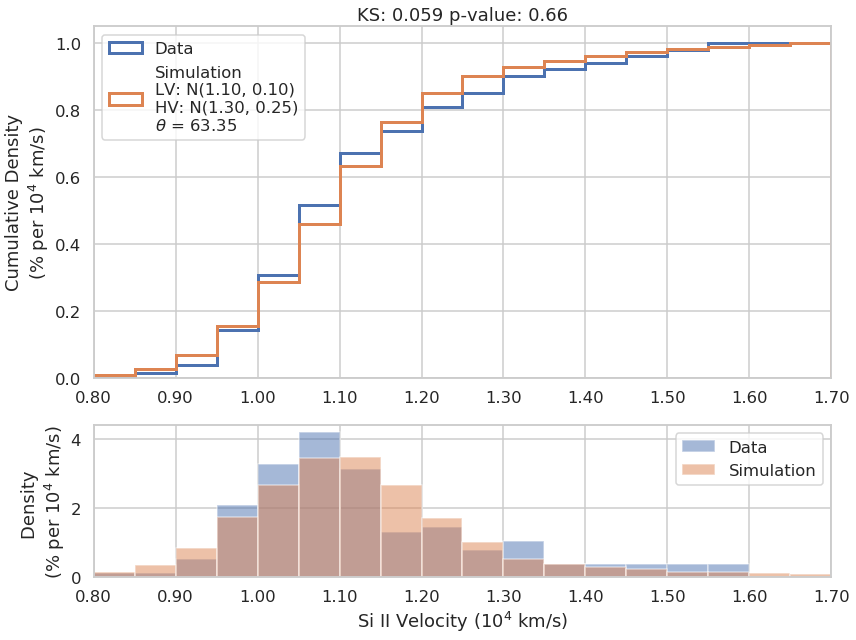

In [26]:
i = 0
best_vs = vs[i]
best_ks = ks[i]
best_pvalue = pvalue[i]
best_params = params[i]
mu_LV, sigma_LV = best_params['mu_LV'], best_params['sigma_LV']
mu_HV, sigma_HV = best_params['mu_HV'], best_params['sigma_HV']
theta = best_params['theta']

plt.figure(figsize=(12, 9))
ax2 = plt.subplot2grid((3,1), (2,0))
ax1 = plt.subplot2grid((3,1), (0,0), rowspan=2, sharex=ax2)

bins = np.arange(0.8, 1.75, 0.05)
ax2.hist(sn_data['v_siII'], bins, density=True,
         alpha=0.5, label='Data')
ax2.hist(best_vs, bins, density=True, 
         alpha=0.5, label=f'Simulation')
ax2.set_xlabel('Si II Velocity ($10^4$ km/s)')
ax2.set_ylabel('Density \n(% per $10^4$ km/s)')


ax1.hist(sn_data['v_siII'], bins, cumulative=True, histtype='step', 
        density=True, linewidth=3, label='Data')
ax1.hist(best_vs, bins, cumulative=True, histtype='step', 
        density=True, linewidth=3, label=(
            f'Simulation\n' + 
            f'LV: N({mu_LV:.2f}, {sigma_LV:.2f})\n' + 
            f'HV: N({mu_HV:.2f}, {sigma_HV:.2f})\n' + 
            fr'$\theta$ = {theta:.2f}'))
ax1.set_ylabel('Cumulative Density\n(% per $10^4$ km/s)')
ax1.set_title(f'KS: {best_ks:.3f} p-value: {best_pvalue:.2f}')

# Plot config
ax1.legend(loc='upper left')

ax2.set_xticks(bins[::2])
ax2.set_xticklabels([f'{tick:.2f}' for tick in bins[::2]])
ax2.set_xlim(bins.min(), bins.max())
ax2.legend()

plt.tight_layout()
plt.savefig('best.png', dpi=300, format='png')

Plotted above is the top KS scoring simulation. The bottom plot is the same plot as the previous figure. The top plot is the cumulative distirbution of the bottom.

# Discussion

The distinction in Si II velocity distribution may be described by asymmetries in SNe Ia's ejecta. We produced a two-dimensional simulation under the assumption that the ejecta asymmetries is only angular (i.e., the ejecta is anisotropic) where the there exist a angular region on the photospheric shell that has a velocity higher than the remaining shell. These two region are labeled as high-velocity ejecta (HV) and low-velocity ejecta (LV). We assume for a given SN Ia, its ejecta velocity of the HV and LV region are of a single value sampled from two normal distributions. The best performing simulations resulted in reasonable and consistent values of the normal distribution's mean and standard deviatons. However, the parameter describing the angular spread of the HV ejecta region varies a lot. Further constraints are required to gather any intuitive conclusion to whether or not the simulation does represent the data. These constraints should come from empirical evidence and existing SNe Ia models.

# References

Hillebrandt, W., & Niemeyer, J. C. 2000, ARA&A, 38, 191

Levanon, N., & Soker, N. 2019, arXiv:1901.05057

Polin, A., Nugent, P. E., & Kasen, D. 2019, ApJ, 873, 1

Silverman, J. M., Kong, J. J., Filippenko, A. V., et al., 2012, MNRAS, 425, 1819

Wang, X., Wang, L., & Filippenko, A. V.  2013, Science, 340, 6129

Zheng, W., Kelly, P. L., & Filippenko, A. V. 2018, ApJ, 858, 104

# Appendix

## Grid Search

```python
import time
import numpy as np
import pickle as pkl
from scipy.stats import norm, ks_2samp
from sklearn.model_selection import ParameterGrid
from dataloader import import_sn_data

param_grid = {
    'theta': np.linspace(0, 180, 180),
    'mu_HV': np.linspace(1.3, 5, 10),
    'sigma_HV': np.linspace(0.1, 0.3, 5),
    'mu_LV': np.linspace(1., 1.3, 10),
    'sigma_LV': np.linspace(0.1, 0.5, 5),
}

def model_vdist(theta, mu_HV, sigma_HV, mu_LV, sigma_LV, sample_size=1000):
    los = np.random.uniform(-180, 180, sample_size)

    cond = (los > -theta/2) & (los < theta/2)
    hv_size = np.sum(cond)
    lv_size = np.sum(~cond)

    vs = np.append(
        np.random.normal(mu_HV, sigma_HV, hv_size),
        np.random.normal(mu_LV, sigma_LV, lv_size)
    )
    return vs


def simulate_grid(vs_data, param_grid, **kwargs):
    param_grid = ParameterGrid(param_grid)
    scores = {
        'vs': [],
        'ks': [],
        'pvalue': [],
        'params': []
    }

    nparams = len(param_grid)
    start = time.perf_counter()
    elapsed_times = []
    for i, params in enumerate(param_grid):
        vs = model_vdist(**params, **kwargs)
        ks, pvalue = ks_2samp(vs_data, vs)

        if i < 100:
            scores['vs'].append(vs)
            scores['ks'].append(ks)
            scores['pvalue'].append(pvalue)
            scores['params'].append(params)
        else:
            max_idx = np.argmax(scores['ks'])
            if ks < scores['ks'][max_idx]:
                scores['vs'][max_idx]= vs
                scores['ks'][max_idx]= ks
                scores['pvalue'][max_idx]= pvalue
                scores['params'][max_idx]= params

        if (i != 0) and (i % (nparams / 100) == 0):
            end = time.perf_counter()
            elapsed_times.append(end-start)
            mean_step_period = np.mean(elapsed_times) / (nparams / 100)
            print(f"Step [{i}/{nparams}] ", end='')
            print(
                # f"{params} " +
                f"KS: {ks:.3f} " +
                f"p-value: {pvalue:.2f} " +
                f"Elapsed Time: {elapsed_times[-1]:.2f} secs " +
                f"ETA: {(nparams - i) * mean_step_period / 60:.2f} mins "
            )
            start = time.perf_counter()

    return {k: np.array(v) for k, v in scores.items()}


if __name__ == "__main__":
    sn_data = import_sn_data()
    scores = simulate_grid(sn_data['v_siII'], param_grid, sample_size=10000)
    print(scores)

    # ks = scores['ks']
    # sort_idx = np.argsort(ks)
    # ks = ks[sort_idx]
    # vs = scores['vs'][sort_idx]
    # params = scores['params'][sort_idx]

    with open('scores.pkl', 'wb') as f:
        # pkl.dump({k: v[:10] for k, v in scores.items()}, f)
        pkl.dump(scores, f)
```